# Can we correctly produce a DPP?

And then sample from it. We want to get the kernel from data first.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn.metrics

# This gives P(A \subset Y) = det(K_A)
def corr_k(K,points):
    Kp = K[points][:,points]

    if len(Kp.shape) > 1: 
        return np.linalg.det(Kp)
    else:
        return K

def select_eigenvalues_from_L(eig_vals):
    N = len(eig_vals)
    indices = np.arange(N)
    bern_probs = eig_vals / (eig_vals + 1)
    
    selected_indices = np.random.rand(N) <= bern_probs
            
    return indices[selected_indices]
    
def select_samples_from_L(eig_vecs):
    samples = [] 
    N, n_samples = V.shape
    indices = np.arange(N)    
    avail = np.ones(N, dtype=bool) 
    
    c = np.zeros((N, n_samples)) # Used for Gram-Schmidt
    normVT2 = (V**2).sum(axis = 1)
    
    for i in range(n_samples):
        probs = normVT2[avail] / (n_samples - i)  
        probs[probs < 0] = 0 # Compensate for small negatives due to round off
        j = np.random.choice(indices[avail], p=probs)

        samples.append(j)
        avail[j] = False
        # Cancel the contribution of V^T_j to the remaining feature vectors
        c[:, i] = (V @ V[j, :] - c[:, 0:i] @ c[j, 0:i]) / np.sqrt(normVT2[j])
        normVT2[:] -= c[:, i]**2

    return np.array(samples)


# K-DPP sampling requires computation of elementary symmetric polynomials
def elementary_symmetric_polynomial(k, eig_vals):
    N = len(eig_vals)
    
    e = np.zeros([k + 1, N + 1])
    e[0, :] = 1.0

    for l in range(1, k + 1):
        for n in range(1, N + 1):
            e[l, n] = e[l, n - 1] + eig_vals[n - 1] * e[l - 1, n - 1]
    return e

def select_k_eigenvalues_from_L(k,eig_vals):

    e = elementary_symmetric_polynomial(k,eig_vals)
    N = len(eig_vals)

    sample_idx = []
    for n in range(N,0,-1):
        thresh = eig_vals[n-1] * e[k-1,n-1] / e[k,n]
        if np.random.rand() <= thresh:
            sample_idx.append(n-1)
            k -= 1
            if k == 0:
                break

    return sample_idx    


In [ ]:
# Generate the points that we sample from
line = np.linspace(0,1,10)
x,y = np.meshgrid(line,line)
d = np.stack([x.flatten(), y.flatten()], axis = 1)

# Kernel is exp( -||d_i - d_j||^2 / N). This is an L-ensemble
dist = np.linalg.norm(d[:,None,:] - d[None,:,:],axis = -1)
N = d.shape[-1]


##### SINE KERNEL
div_val = 30
L = np.sin(np.pi * dist / div_val) / (np.pi * dist / div_val) 
L[np.isnan(L)] = 1 # sin(x)/x = 1


############################### For sampling
##### Get EigenValues
eig_vals, eig_vecs = np.linalg.eigh(L)


##### Calculate marginal kernel (K)
K = eig_vecs @ np.diag(eig_vals / (eig_vals + 1)) @ eig_vecs.T

print('N')
print(N)

print('Expected Cardinality of Samples')
print(np.sum( eig_vals / (eig_vals + 1)))

print('Variance of Cardinality Samples')
print(np.sum( eig_vals / (eig_vals + 1)**2 ))

print('Eigenvalues')
print(eig_vals[0:10])

In [ ]:
# What is the probability of each point with no points selected
colors = np.diag(K)
plt.scatter(d[:,0],d[:,1],c = colors, cmap = 'gray')
plt.axis('off')
plt.show()

point_idx = []
vals_to_add = np.array([90,9,99,0, 45])
# vals_to_add = vals_to_add * 25 
for val in vals_to_add:
    point_idx.append(val)
    # Ok, we have a point. Now the probabilities are updated 

    # Bust out some bayes: p(a|b) = p(a and b) / p(b)
    # p(a and b) = K[point_idx,point_idx] K[i,i] - (K[i,point_idx])**2
    # p(b) = K[point_idx,point_idx]

    def corr_k(K,points):
        Kp = K[points][:,points]

        if len(Kp.shape) > 1: 
            return np.linalg.det(Kp)
        else:
            return K


    p = []
    idxs = []
    for i in range(d.shape[0]):
        points = [i]
        points.extend(point_idx)
        if i in point_idx:
            continue        
        idxs.append(i)
        prob = corr_k(K,points) / corr_k(K,point_idx)
        p.append(prob)
    
    plt.scatter(d[idxs,0],d[idxs,1],c = p, cmap = 'gray')
    plt.scatter(d[point_idx,0],d[point_idx,1] ,color = 'red')
    plt.axis('off')
    plt.show()

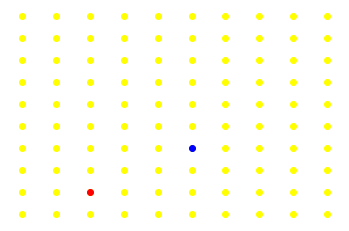

In [4]:
##### Sample from DPP in a two stage process
# Select eigenvectors
vec_idx = select_eigenvalues_from_L(eig_vals) 
V = eig_vecs[:,vec_idx]

# Select samples from eigenvalues
sample_idx = select_samples_from_L(V)

samples = d[sample_idx,:]


n = d.shape[0]

p_samples = np.random.choice(n,size = len(samples))
p_samples = d[p_samples,:]

plt.scatter(d[:,0],d[:,1], color = 'yellow')
plt.scatter(samples[:,0], samples[:,1], color = 'red')
# plt.show()

plt.scatter(p_samples[:,0], p_samples[:,1], color = 'blue')


plt.axis('off')

plt.show()


# Sampling from k-DPPs


DPPs provide a flexible way of modeling the content of sets of random points. However, it is not straightforward to have strict control over the cardinality of these sets. Thus, we turn to $k$-DPPs. $k$-DPPs are DPPs conditional on the DPP containing $k$ points. 

The conditional probabilities of the $k$-DPPs are not DPPs aside from some simple cases. However, there exist efficient methods to sample from them none the less. Here, we implement methods to sample from $k$-DPPs.






One major drawback of sampling $k$-DPPs is that it requires the spectral decomposition of of $L,K$ matrices. There are methods for sampling from $DPPs$ that rely on the Cholesky decomposition — side-stepping $n^3$ spectral decomposition. 

This paper: https://arxiv.org/pdf/2006.16947.pdf

Might have a better way of sampling from $k$-DPPs but it's a significantly more involved process and less efficient for small problems.


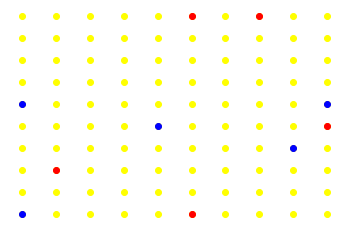

In [5]:
# Sample from a k-DPP - Notice that red points are more spread out

k = 5
vec_idx = select_k_eigenvalues_from_L(k,eig_vals) 
V = eig_vecs[:,vec_idx]

# Select samples from eigenvalues
sample_idx = select_samples_from_L(V)
samples = d[sample_idx,:]


n = d.shape[0]

p_samples = np.random.choice(n,size = len(samples))
p_samples = d[p_samples,:]

plt.scatter(d[:,0],d[:,1], color = 'yellow')
plt.scatter(samples[:,0], samples[:,1], color = 'red')
# plt.show()

plt.scatter(p_samples[:,0], p_samples[:,1], color = 'blue')

plt.axis('off')
plt.show()

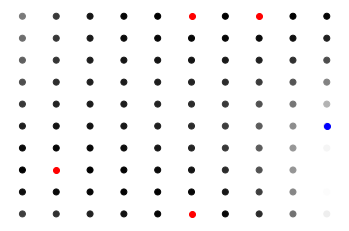

In [6]:
##### Conditional probabilities given the k-DPP sample above

point_idx = sample_idx[:-1].tolist()
next_realized_point = [sample_idx[-1].tolist()]

p = []
idxs = []
for i in range(d.shape[0]):
    points = [i]
    points.extend(point_idx)
    if i in point_idx:
        continue        
    idxs.append(i)
    prob = corr_k(K,points) / corr_k(K,point_idx)
    p.append(prob)

plt.scatter(d[idxs,0],d[idxs,1],c = p, cmap = 'gray') # Plot probabilities
plt.scatter(d[point_idx,0],d[point_idx,1] ,color = 'red') # Plot conditioning points
plt.scatter(d[next_realized_point,0],d[next_realized_point,1] ,color = 'blue') # Plot conditioning points
plt.axis('off')
plt.show()

# Linear Regression with duplicated input variables

Related to the proof.   

In [346]:
# First we have to build a linear regression problem.
from sklearn.linear_model import LinearRegression
d = 10
n = 10000
sigma = 0.1 # The noise associated with our labels: y = <theta, x> + w, w ~ N(0,sigma^2)
theta = np.random.rand(d)* 10 # We'll seek to estimate this theta

X = np.random.rand(n,d) # Our true data
noisy_X =  X + 0.1 * np.random.randn(X.shape[0],X.shape[1])
y = (X @ theta) + sigma * np.random.randn(n)

# Check we can solve it well
reg = LinearRegression(fit_intercept = False)
reg.fit(noisy_X, y)
print('Coefficients found via Regression')
print(reg.coef_)
print('True coefficients')
print(theta)
print('Score value')
reg.score(X, y)

Coefficients found via Regression
[3.8208719  3.88685153 7.34094599 8.45141622 5.72838271 1.20863138
 4.25687366 4.47058342 7.74663386 8.3515691 ]
True coefficients
[3.7096272  3.56035115 7.6821249  8.81632679 5.83897429 0.67717729
 4.03884516 4.42837983 8.05126591 8.70672425]
Score value


0.9966774790677928

In [351]:
# Ok, we can learn well. That's good. Let's simulate our problem
# Need to duplicate our variables
Z = np.concatenate([X,X], axis = 1)

## Add noise to them
Z = Z + 0.01 * np.random.randn(Z.shape[0],Z.shape[1])

# And shuffle them 
np.random.shuffle(Z.transpose()) # Now Z represents our redundant data

In [352]:
# Now, let's try the k-bernoulli selection of d columns
selected_columns = np.random.choice(d*2, size = d, replace = False)
## These are the columns you are selecting
print('These are the columns that we are selecting')
print(selected_columns)    
print('They correspond to the variables')
print(selected_columns % d)
    
Xhat = Z[:,selected_columns]  


# Check we can solve it well
reg = LinearRegression(fit_intercept = False)
reg.fit(Xhat, y)
print('Coefficients found via Regression')
print(reg.coef_)
print('True coefficients')
print(theta)
print('Score value')
reg.score(Xhat, y)

These are the columns that we are selecting
[ 8  5  9  1  2  7 14 10 18 11]
They correspond to the variables
[8 5 9 1 2 7 4 0 8 1]
Coefficients found via Regression
[ 1.66245406  2.04308709 10.30534764  6.10364685  9.23634726  6.12032411
  7.36524934  5.31063782  7.92890424 -1.02902625]
True coefficients
[3.7096272  3.56035115 7.6821249  8.81632679 5.83897429 0.67717729
 4.03884516 4.42837983 8.05126591 8.70672425]
Score value


0.7021270575048436

In [353]:
## Ok, now let's select the variables that we keep according to a DPP
dist = np.linalg.norm(Z.transpose()[:,None,:] - Z.transpose()[None,:,:],axis = -1)
L = np.exp(- 40 * dist**2 / Z.shape[0] ) 
eig_vals, eig_vecs = np.linalg.eigh(L)
vec_idx = select_k_eigenvalues_from_L(d,eig_vals) 
V = eig_vecs[:,vec_idx]
# Select samples from eigenvalues
selected_columns = select_samples_from_L(V)

## These are the columns you are selecting
print('These are the columns that we are selecting')
print(selected_columns)    
print('They correspond to the variables')
print(selected_columns % d)
    
Xhat = Z[:,selected_columns]  


# Check we can solve it well
reg = LinearRegression(fit_intercept = False)
reg.fit(Xhat, y)
print('Coefficients found via Regression')
print(reg.coef_)
print('True coefficients')
print(theta)
print('Score value')
reg.score(Xhat, y)

These are the columns that we are selecting
[15 11  7  9  0 18  6 12 13 14]
They correspond to the variables
[5 1 7 9 0 8 6 2 3 4]
Coefficients found via Regression
[0.68065072 3.56223639 4.42954053 8.70963632 3.7185315  8.05363553
 4.02842133 7.68084529 8.80531886 5.84201543]
True coefficients
[3.7096272  3.56035115 7.6821249  8.81632679 5.83897429 0.67717729
 4.03884516 4.42837983 8.05126591 8.70672425]
Score value


0.9984921148045173